# Introducci√≥n
En este proyecto desarrollamos un sistema de clasificaci√≥n autom√°tica para predecir el estado de √°nimo (mood) de canciones en base a sus caracter√≠sticas sonoras. El objetivo es construir modelos de machine learning que, a partir de variables como la danzabilidad, la energ√≠a, la valencia, el tempo, entre otras, sean capaces de identificar a qu√© tipo de mood pertenece una canci√≥n.

El flujo general del trabajo se divide en varias etapas:

*  Preprocesamiento de datos: limpiamos el conjunto de datos original y normalizamos sus caracter√≠sticas mediante StandardScaler para asegurar una correcta interpretaci√≥n por parte de los modelos.

*  Generaci√≥n de etiquetas con KMeans: como no contamos con etiquetas de mood en el dataset original, aplicamos un algoritmo de clustering (KMeans) para agrupar las canciones en distintos estados de √°nimo. Cada canci√≥n recibe una etiqueta basada en el cl√∫ster al que pertenece.

*  Clasificaci√≥n supervisada: con estas nuevas etiquetas, transformamos el problema en uno de clasificaci√≥n supervisada. Entrenamos y comparamos cuatro modelos distintos:
    *  Random Forest
    *  K-Nearest Neighbors (KNN)
    *  Regresi√≥n Log√≠stica
    *  M√°quinas de Vectores de Soporte (SVM)

Cada modelo es ajustado mediante GridSearchCV para encontrar la mejor combinaci√≥n de hiperpar√°metros utilizando validaci√≥n cruzada. Luego se eval√∫a su rendimiento sobre un conjunto de prueba mediante m√©tricas como accuracy, classification report y matriz de confusi√≥n.

* Evaluaci√≥n y visualizaci√≥n: finalmente, analizamos los resultados de cada modelo para determinar cu√°l es m√°s eficaz en la tarea de clasificaci√≥n. Tambi√©n visualizamos gr√°ficamente los resultados y comparamos las predicciones con las etiquetas reales.

In [25]:
# Imports
import sys
import os

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from kneed import KneeLocator
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import time
import logging
import joblib

# [Alex] Define the paths of the data here?
# [Alex] Add requirements.txt and install all modules

## An√°lisis de los datos

In [3]:
# Cargar el dataset
in_spotify_dataset = './Source/tracks.csv'

df_tracks = pd.read_csv(in_spotify_dataset)
print(f"{df_tracks.head()}")

                       id                                 name  popularity  \
0  35iwgR4jXetI318WEWsa1Q                                Carve           6   
1  021ht4sdgPcrDgSk7JTbKY  Cap√≠tulo 2.16 - Banquero Anarquista           0   
2  07A5yehtSnoedViJAZkNnc   Vivo para Quererte - Remasterizado           0   
3  08FmqUhxtyLTn6pAh6bk45        El Prisionero - Remasterizado           0   
4  08y9GfoqCWfOGsKdwojr5e                  Lady of the Evening           0   

   duration_ms  explicit              artists                  id_artists  \
0       126903         0              ['Uli']  ['45tIt06XoI0Iio4LBEVpls']   
1        98200         0  ['Fernando Pessoa']  ['14jtPCOoNZwquk5wd9DxrY']   
2       181640         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
3       176907         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
4       163080         0      ['Dick Haymes']  ['3BiJGZsyX9sJchTqcSA7Su']   

  release_date  danceability  energy  key  loudness  mode  speechin

Con la funci√≥n head podemos ver cada una de las columans que forman el dataset. A continuaci√≥n, se explica la informaci√≥n que obtenemos de cada una de ellas:

* id: Identificador √∫nico de cada canci√≥n proporcionado por Spotify.
* name: Nombre o t√≠tulo de la canci√≥n.
* popularity: Popularidad actual de la canci√≥n en Spotify (0 = menos popular, 100 = m√°s popular).
* duration_ms: Duraci√≥n de la canci√≥n en milisegundos.
* explicit: Indica si la canci√≥n contiene contenido expl√≠cito (1 = expl√≠cito, 0 = no expl√≠cito).
* artists: Nombre(s) del artista(s) que interpretan la canci√≥n.
* id_artists: Identificadores √∫nicos en Spotify de los artistas correspondientes.
* release_date: Fecha en la que se lanz√≥ originalmente la canci√≥n (formato YYYY-MM-DD).
* danceability: Qu√© tan adecuada es una canci√≥n para bailar (0.0 = menos bailable, 1.0 = m√°s bailable).
* energy: Energ√≠a y nivel de actividad percibido en la canci√≥n (0.0 = menos energ√©tica, 1.0 = m√°s energ√©tica).
* key: Tono o clave musical en la que est√° compuesta la canci√≥n (valores num√©ricos de 0 a 11 que corresponden a notas musicales).
* loudness: Volumen promedio de la canci√≥n en decibelios (dB).
* mode: Modalidad de la canci√≥n (0 = menor, 1 = mayor).
* speechiness: Medida de cu√°nto contenido hablado tiene una canci√≥n (0.0 = poca o ninguna, cerca de 1.0 = predominantemente hablada).
* acousticness: Indica qu√© tan ac√∫stica es la canci√≥n (0.0 = menos ac√∫stica, 1.0 = muy ac√∫stica).
* instrumentalness: Indica la probabilidad de que una canci√≥n sea instrumental (m√°s cercano a 1.0 significa mayor probabilidad instrumental, 0.0 es t√≠picamente vocal).
* liveness: Indica la probabilidad de que la canci√≥n haya sido grabada en vivo (m√°s cercano a 1.0 indica alta probabilidad de que sea en vivo).
* valence: Indica la positividad o felicidad que transmite una canci√≥n (0.0 = m√°s triste o negativa, 1.0 = m√°s alegre o positiva).
* tempo: Velocidad o ritmo de la canci√≥n medida en BPM (pulsos por minuto).
* time_signature: N√∫mero de pulsos por comp√°s en la canci√≥n (por ejemplo: 4 indica comp√°s de 4/4).


A continuaci√≥n, comprobamos el n√∫mero de columnas y filas que conforman nuestro dataset:

In [4]:

print(f"Shape de df_tracks:\n{df_tracks.shape}")

print(f"Info de df_tracks:\n{df_tracks.info()}")

Shape de df_tracks:
(586672, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  

Podemos ver que el fichero a estudiar tiene 586672 canciones con 20 columnas con la informaci√≥n de cada una.
Para conocer el tipo de dato de cada columna y su nulabilidad utilizamos la funci√≥n info():


Gracias al resultado anterior, podemos deducir lo siguiente:
* El dataset tiene un total de 586,672 registros (filas).
* Posee 20 columnas.
* La mayor√≠a de columnas est√°n completas, con pocos datos faltantes:
  * Solo la columna "name" tiene valores nulos (71 valores faltantes).
* Los tipos de datos incluyen:
  *  texto: id, name, artists, id_artists, release_date
  *  n√∫meros enteros: popularity, duration_ms, explicit, key, mode, time_signature
  *  n√∫meros decimales: danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo
* El dataset utiliza aproximadamente 89.5 MB de memoria


Puesto que el prop√≥sito del proyecto es conocer el mood de cada una de las canciones del dataset para poder recomendar al usuario seg√∫n su estado an√≠mico, es necesario quedarnos exclusivamente con las features que aporten un significado a la variable objetivo (mood). Para ello, vamos a analizar una a una para conocer el listado final de features a utilizar para obtener el mood de cada canci√≥n.



| Columna           | √ötil para el mood | Raz√≥n concreta                                                                                   |
|-------------------|-------------------|--------------------------------------------------------------------------------------------------|
| id                | ‚ùå                | Identificador √∫nico, no contiene informaci√≥n emocional o musical.                               |
| name              | ‚ùå                | Es solo el t√≠tulo de la canci√≥n, no representa caracter√≠sticas de audio o emoci√≥n.              |
| popularity        | ‚ùå                | Es un indicador social, no emocional ni ac√∫stico.                                                |
| duration_ms       | ‚ùå                | La duraci√≥n no determina directamente el estado de √°nimo.                                       |
| explicit          | ‚ùå                | Indica lenguaje expl√≠cito, no es un indicador directo del mood musical.                         |
| artists           | ‚ùå                | Nombre del artista no describe directamente el sonido o emoci√≥n de la canci√≥n.                  |
| id_artists        | ‚ùå                | Es un identificador t√©cnico, sin relaci√≥n con el mood.                                          |
| release_date      | ‚ùå                | La fecha de publicaci√≥n no describe el tono emocional o caracter√≠sticas del audio.              |
| danceability      | ‚úÖ                | Describe qu√© tan f√°cil es bailar la canci√≥n, influye directamente en el mood.                   |
| energy            | ‚úÖ                | Cuantifica la intensidad de la canci√≥n, clave en la percepci√≥n emocional.                       |
| key               | ‚ùå                | Es la nota musical base, pero no determina por s√≠ sola el estado de √°nimo.                      |
| loudness          | ‚úÖ                | Canciones m√°s fuertes suelen sentirse m√°s energ√©ticas o intensas.                               |
| mode              | ‚ùå                | Indica mayor o menor, pero es una caracter√≠stica muy general del tono.                          |
| speechiness       | ‚úÖ                | Ayuda a distinguir canciones habladas o rapeadas, cambia la percepci√≥n emocional.               |
| acousticness      | ‚úÖ                | Cuantifica si es ac√∫stica; sonidos ac√∫sticos suelen sentirse m√°s suaves o √≠ntimos.              |
| instrumentalness  | ‚úÖ                | Alta instrumentalidad suele asociarse con calma o ambiente.                                     |
| liveness          | ‚úÖ                | Indica si fue grabada en vivo; puede transmitir diferentes emociones.                           |
| valence           | ‚úÖ                | Describe qu√© tan positiva o alegre es la canci√≥n, directamente ligado al mood.                  |
| tempo             | ‚úÖ                | Ritmo de la canci√≥n, afecta energ√≠a y sensaci√≥n emocional.                                      |
| time_signature    | ‚ùå                | Es la m√©trica musical; tiene poco impacto en c√≥mo percibimos el mood.                          |


[Alex] Understand what are the final features and why?, 

In [5]:
FEATURES = ['valence','energy','danceability','tempo','loudness']

Una vez analizadas las columnas del dataset, las features interesantes a utilizar son:
* danceability
*  energy
*  loudness
*  speechiness
*  acousticness
*  instrumentalness
*  liveness
*  valence
*  tempo

Con estas features ya podemos hacer uso de la funci√≥n clean_normalize_dataset() que hemos creado en el fichero final_models.py. 

Esta funci√≥n clean_normalize_dataset realiza tres tareas principales sobre un conjunto de datos:

*  Carga y limpieza: Lee el archivo CSV de entrada (tracks.csv), escoge las columnas que hemos seleccionado (FEATURES) y elimina las filas con valores nulos.

*  Normalizaci√≥n: Escala los datos num√©ricos usando StandardScaler para que tengan media 0 y desviaci√≥n est√°ndar 1. Este proceso mejora el rendimiento de muchos algoritmos de machine learning y evita que variables con valores grandes dominen sobre otras m√°s peque√±as.

*  Guardado de resultados: primero guarda el objeto escalador (scaler) como archivo .pkl por si lo tenemos que utilizar de nuevo, y tambi√©n guarda el nuevo dataset normalizado como archivo .csv.

A continuaci√≥n, usamos esta funci√≥n y observamos los resultados:

In [6]:
def clean_normalize_dataset(input_csv: str, scaled_output_pkl: str, scaler_output_pkl: str):

    start_time = time.time()
    print(f"Clean and Normalize Dataset")

    df = pd.read_csv(input_csv)
    df = df[FEATURES].dropna().copy()

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df)
    joblib.dump(scaler, scaler_output_pkl)

    scaled_df = pd.DataFrame(data_scaled, columns=FEATURES)
    joblib.dump(scaled_df, scaled_output_pkl)

    print(f"Completed in {time.time() - start_time:.2f} seconds")

out_data_scaled_pkl = './Data/data_scaled.pkl'
out_scaler_pkl = './Data/scaler.pkl'

clean_normalize_dataset(in_spotify_dataset, out_data_scaled_pkl, out_scaler_pkl)
df_tracks_cleaned = joblib.load('./Data/data_scaled.pkl')

print(f"\nShape: {df_tracks_cleaned.shape}")

print(f"\nInformation\n: {df_tracks_cleaned.info()}") #Why None
print(f"\nDescription\n: {df_tracks_cleaned.describe()}")

Clean and Normalize Dataset
Completed in 2.00 seconds

Shape: (586672, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   valence       586672 non-null  float64
 1   energy        586672 non-null  float64
 2   danceability  586672 non-null  float64
 3   tempo         586672 non-null  float64
 4   loudness      586672 non-null  float64
dtypes: float64(5)
memory usage: 22.4 MB

Information
: None

Description
:             valence        energy  danceability         tempo      loudness
count  5.866720e+05  5.866720e+05  5.866720e+05  5.866720e+05  5.866720e+05
mean  -2.083163e-16  1.075494e-16 -8.904311e-17  2.830195e-16 -3.771010e-16
std    1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00
min   -2.143404e+00 -2.151596e+00 -3.393048e+00 -3.980128e+00 -9.783998e+00
25%   -8.006050e-01 -7.900676e-01 -6.658166e-01 -7.6

Vemos que en el dataset resultante no quedan valores nulos en ninguna de las columnas, y con la funci√≥n describe() podemos ver el resultado de la normalizaci√≥n:

array([[<Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'energy'}>],
       [<Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'tempo'}>],
       [<Axes: title={'center': 'loudness'}>, <Axes: >]], dtype=object)

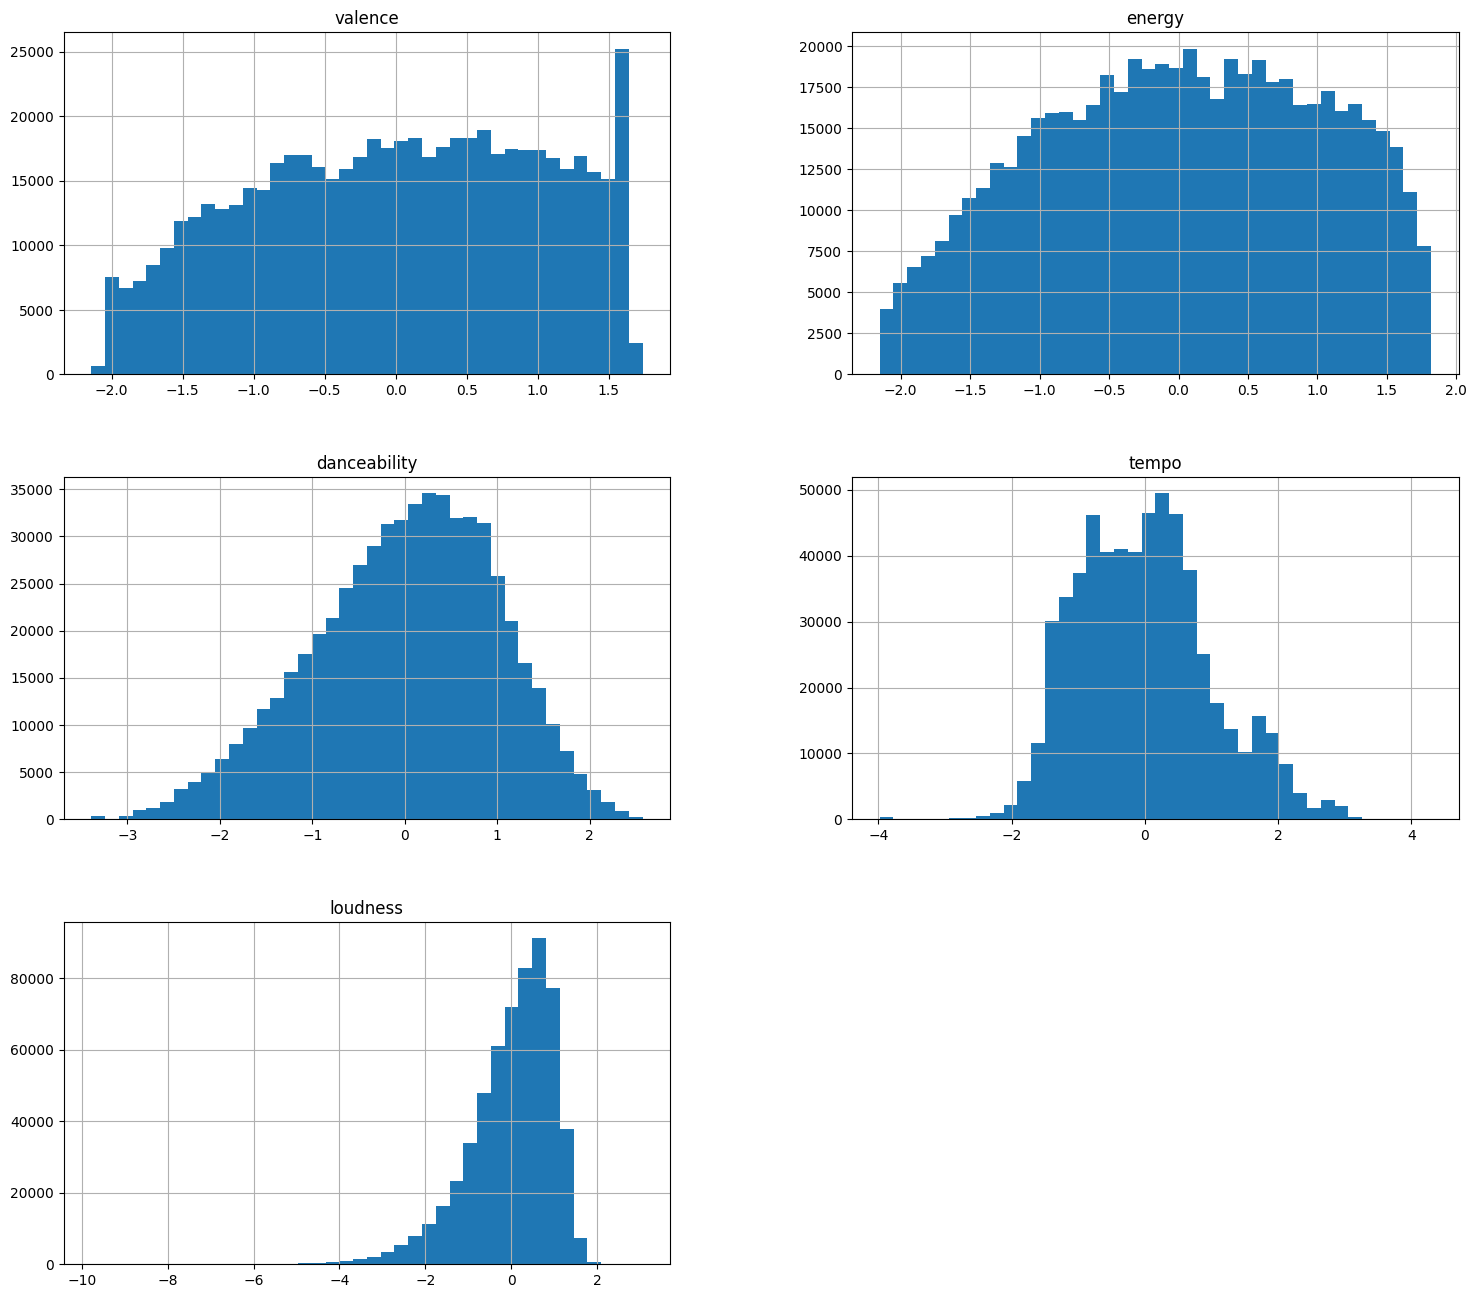

In [7]:
df_tracks_cleaned.hist(bins= 40, figsize= (18 , 16))

Con la funci√≥n hist() aplicada a nuestro dataset podemos observar las distribuciones de los valores de cada feature para todas las canciones, pudiendo identificar los outliers. Sin embargo, en datasets musicales como este, los valores extremos no necesariamente son errores ni datos at√≠picos indeseables, sino que pueden representar caracter√≠sticas reales e importantes de ciertos g√©neros musicales o canciones √∫nicas.

Algunas variables como danceability, tempo, valence o energy tienen distribuciones m√°s o menos normales. Otras como speechiness, instrumentalness, liveness, muestran colas largas o concentraciones extremas, lo cual es esperado y v√°lido en audio/m√∫sica. Por ejemplo, Speechiness puede estar muy cerca de 0 para m√∫sica instrumental y cerca de 1 para hip hop. Otro ejemplo, puede ser para Instrumentalness que puede tener valor 0 para canciones vocales y valor muy alto en canciones sin voz.

A continuaci√≥n, vamos a representar la Matriz de correlaci√≥n. Con esta podemos ver la relaci√≥n entre las distintas features que conforman nuestro dataset. En caso de que hubiera una gran relaci√≥n entre varias, podr√≠amos prescindir de una de ellas al tener valores muy similares. 



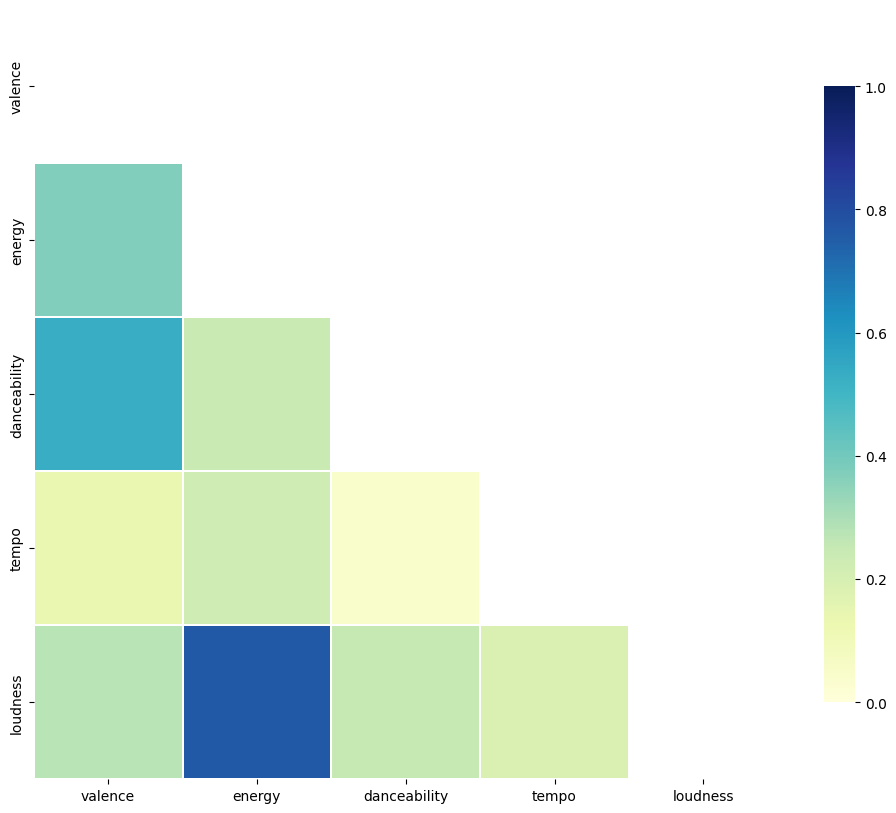

In [8]:
# Compute the correlation matrix
corr = np.abs(df_tracks_cleaned.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmin=0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

# Show the plot
plt.show()

Como resultado, podemos decir que los valores de correlaci√≥n (color m√°s oscuro) est√°n todos por debajo de 0.7, lo cual indica:
*  No hay variables altamente correlacionadas entre s√≠ (lo que justificar√≠a eliminar alguna por redundancia).
*  Cada feature parece aportar informaci√≥n distinta.

En el caso, por ejemplo, de energy y loudness, tienen la correlaci√≥n m√°s alta (aproximadamente 0.6), lo cual es l√≥gico ya que la m√∫sica en√©rgica tiende a sonar m√°s fuerte, pero no es suficiente como para considerar una de las dos innecesaria.

Otro ejemplo, son las variables como speechiness, instrumentalness, liveness tienen correlaciones muy bajas con casi todo lo dem√°s, lo que significa que est√°n capturando aspectos √∫nicos.

En este caso, no tenemos que eliminar ninguna variable porque no hay una correlaci√≥n fuerte ni redundancia evidente entre ninguna de las variables. Eliminar√≠amos una variable en caso de que la correlaci√≥n con otra fuera igual o mayor a 0.9.

## K-means

KMeans es un algoritmo de aprendizaje no supervisado que agrupa datos similares en k grupos llamados cl√∫steres. Funciona ubicando centros (centroides) en el espacio de los datos y asignando cada punto al centro m√°s cercano, ajustando esos centros hasta estabilizar los grupos.

Para este caso, puesto que queremos clasificar canciones en un mood concreto, KMeans las agrupa seg√∫n tengan perfiles similares (por ejemplo, energ√≠a alta y valence bajo), lo que permite identificar distintos "moods" musicales sin etiquetas previas. As√≠ podremos clasificar cada canci√≥n autom√°ticamente en grupos como por ejemplo, alegres, tristes, relajadas o intensas, seg√∫n sus caracter√≠sticas sonoras.

Primero vamos a comprobar cu√°l es el n√∫mero √≥ptimo de clusters para este caso utilizando el m√©todo codo. El m√©todo codo funciona trazando la variaci√≥n dentro del cluster en funci√≥n del n√∫mero de clusters. La idea es elegir el n√∫mero de clusters de modo que al agregar otro cluster no se reduzca sustancialmente la variaci√≥n dentro del cluster. Esto produce un gr√°fico donde la disminuci√≥n de la variaci√≥n ser√° grande para los primeros clusters, y luego se estabilizar√°, creando un "codo" en el gr√°fico. El codo nos indicar√° el n√∫mero de clusters a escoger, teniendo en cuenta que cada cluster representa un mood musical.

#### M√©todo del codo

In [22]:
data_scaled_for_kmeans = joblib.load(out_data_scaled_pkl)

num_rows, num_columns = data_scaled_for_kmeans.shape
sample_sil = round((num_rows-1)*0.05) #5% Dataset

print(f"Running Kmeans from 2 to 12 Clusters")
wcss_results = []
sil_results = []
ch_results = []
db_results = []

k_range = range(2, 13)
for k in k_range:
    print(f"  Running K-Means for k={k}...")
    start_time = time.time()

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit_predict(data_scaled_for_kmeans)

    wcss_results.append(kmeans.inertia_)
    sil_score = silhouette_score(
        data_scaled_for_kmeans,
        kmeans.labels_,
        metric='euclidean',
        sample_size=sample_sil, 
        random_state=42,
        n_jobs=-1
    )
    sil_results.append(sil_score)
    ch_score = calinski_harabasz_score(data_scaled_for_kmeans, kmeans.labels_)
    ch_results.append(ch_score)
    db_score = davies_bouldin_score(data_scaled_for_kmeans, kmeans.labels_)
    db_results.append(db_score)

    print(f"  Completed K={k} in {time.time() - start_time:.2f} seconds")

# Print the results
results_kmeans = pd.DataFrame({
    'k': list(k_range),
    'WCSS': wcss_results,
    'Silhouette Score': sil_results,
    'Calinski-Harabasz': ch_results,
    'Davies-Bouldin': db_results
})

Running Kmeans from 2 to 12 Clusters
  Running K-Means for k=2...
  Completed K=2 in 21.12 seconds
  Running K-Means for k=3...
  Completed K=3 in 22.25 seconds
  Running K-Means for k=4...
  Completed K=4 in 22.77 seconds
  Running K-Means for k=5...
  Completed K=5 in 24.65 seconds
  Running K-Means for k=6...
  Completed K=6 in 26.04 seconds
  Running K-Means for k=7...
  Completed K=7 in 25.89 seconds
  Running K-Means for k=8...
  Completed K=8 in 28.64 seconds
  Running K-Means for k=9...
  Completed K=9 in 27.61 seconds
  Running K-Means for k=10...
  Completed K=10 in 30.22 seconds
  Running K-Means for k=11...
  Completed K=11 in 32.84 seconds
  Running K-Means for k=12...
  Completed K=12 in 34.98 seconds



 k         WCSS  Silhouette Score  Calinski-Harabasz  Davies-Bouldin
 2 2.041038e+06           0.28427       256487.18170         1.39106
 3 1.707615e+06           0.22988       210560.10769         1.49232
 4 1.508801e+06           0.20406       184638.70857         1.44170
 5 1.339246e+06           0.20970       174579.72196         1.35268
 6 1.240260e+06           0.20171       160174.52651         1.30243
 7 1.152987e+06           0.19541       150982.94120         1.32451
 8 1.085812e+06           0.18309       142605.37853         1.36721
 9 1.022329e+06           0.18746       137081.28168         1.32243
10 9.709767e+05           0.18576       131741.38993         1.30765
11 9.339298e+05           0.18097       125597.86825         1.32330
12 8.989994e+05           0.18092       120688.38217         1.33401

Best k based on WCSS: k = 12.0
Best k based on Silhouette Score: k = 2.0
Best k based on Calinski-Harabasz: k = 2.0
Best k based on Davies-Bouldin: k = 6.0
Best k based o

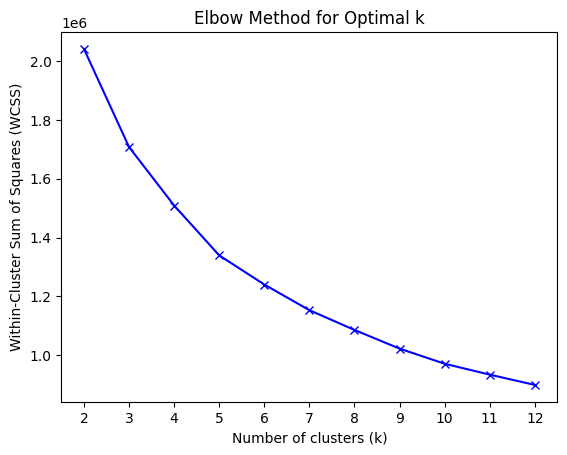

In [24]:
# Print Results of the Kmeans
print(f"\n{results_kmeans.round(5).to_string(index=False)}\n")

# Find the best k for each metric
best_k_wcss = results_kmeans.loc[results_kmeans['WCSS'].idxmin()]['k']
best_k_silhouette = results_kmeans.loc[results_kmeans['Silhouette Score'].idxmax()]['k']
best_k_calinski = results_kmeans.loc[results_kmeans['Calinski-Harabasz'].idxmax()]['k']
best_k_davies = results_kmeans.loc[results_kmeans['Davies-Bouldin'].idxmin()]['k']
best_k_knee = KneeLocator(list(k_range), wcss_results, curve='convex', direction='decreasing')

# Print the results
print(f"Best k based on WCSS: k = {best_k_wcss}")
print(f"Best k based on Silhouette Score: k = {best_k_silhouette}")
print(f"Best k based on Calinski-Harabasz: k = {best_k_calinski}")
print(f"Best k based on Davies-Bouldin: k = {best_k_davies}")
print(f"Best k based on KneeLocator: k = {best_k_knee.knee}")

# Plotting the Elbow Method
plt.plot(list(k_range), wcss_results, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')

plt.xticks(range(2, 13))

# Display the plot
plt.show()

In [26]:
# [Alex] Explain the election of the K
k_optimal = 5

Podemos ver que el codo en este caso se forma en el cluster n√∫mero 6, por lo que ejecutaremos el algoritmo K-means con k=6.

#### Aplicaci√≥n de KMeans y asignaci√≥n de clusters
Para la aplicaci√≥n del algoritmo KMeans, se ha creado la funci√≥n train_knn en el fichero final_models.py. El c√≥digo de esta funci√≥n es el siguiente:

```python
pegar c√≥digo aqui!!!!!!!!!
```

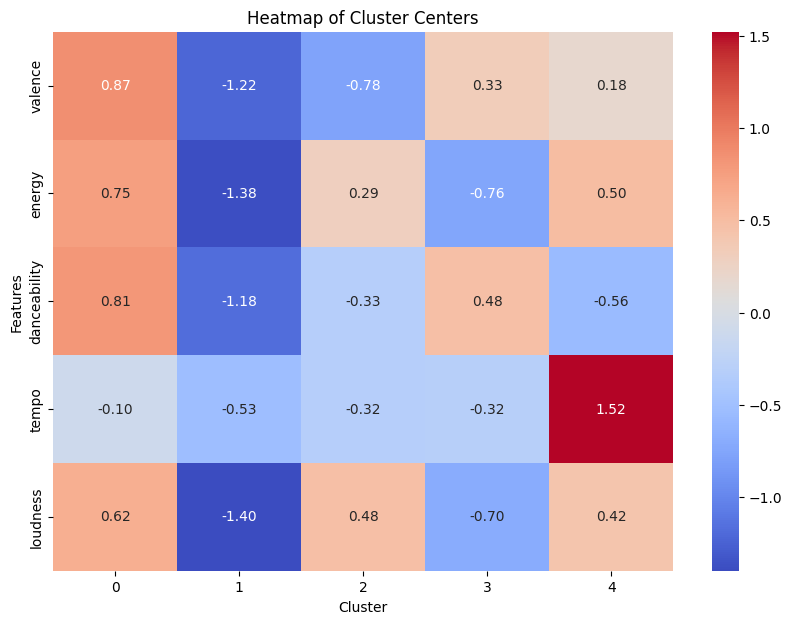

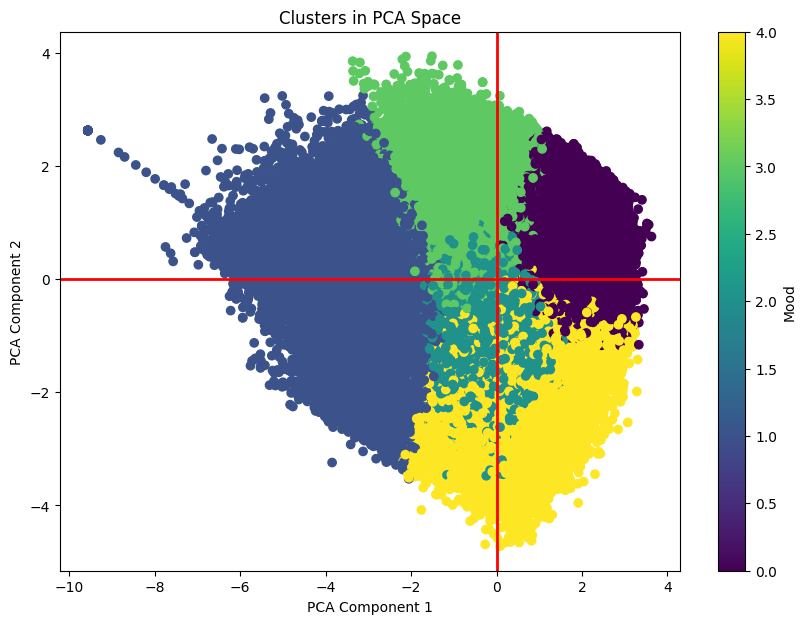

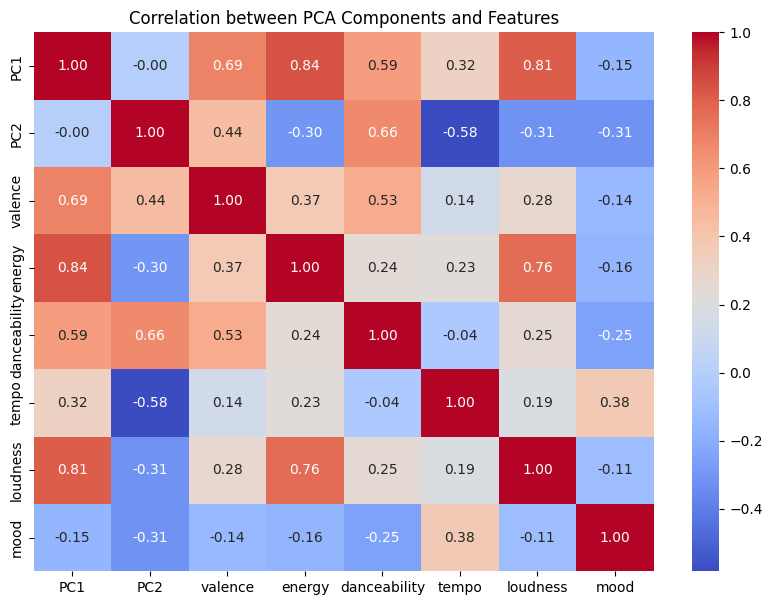

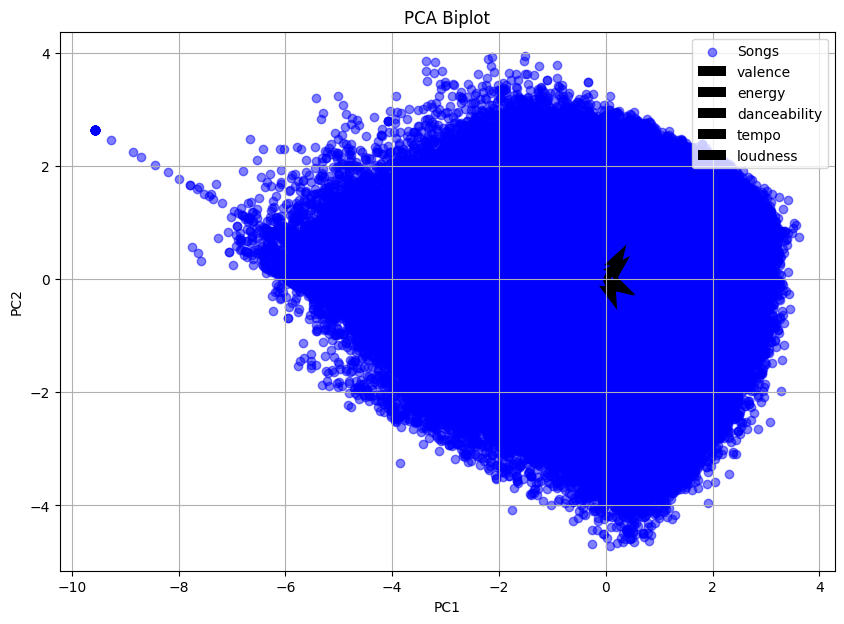

In [27]:
data_scaled_for_analysis = joblib.load(out_data_scaled_pkl)

kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
data_scaled_for_analysis['mood'] = kmeans.fit_predict(data_scaled_for_analysis)

# Perform PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled_for_analysis[FEATURES])

# 1. Plotting the heatmap of the clusters first (based on mood)
plt.figure(figsize=(10, 7))
sns.heatmap(data_scaled_for_analysis.groupby('mood').mean().T, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Cluster Centers')
plt.ylabel('Features')
plt.xlabel('Cluster')
plt.show()

# 2. Plotting the clusters in PCA space (after the heatmap)
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=data_scaled_for_analysis['mood'], cmap='viridis')
plt.title('Clusters in PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.axhline(0, color='r', linewidth=2)
plt.axvline(0, color='r', linewidth=2)

plt.colorbar(label='Mood')
plt.show()

# Create a DataFrame to analyze the correlation between PCA components and original features
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df = pd.concat([pca_df, data_scaled_for_analysis], axis=1)
correlation_matrix = pca_df.corr()

# 3. Plotting the heatmap of the correlation between PCA components and features
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between PCA Components and Features")
plt.show()

# 4. Plotting the PCA biplot (after the correlation heatmap)
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', alpha=0.5, label="Songs")

for i, feature in enumerate(FEATURES):
    plt.quiver(0, 0, pca.components_[0, i], pca.components_[1, i], angles='xy', scale_units='xy', scale=1, label=feature)

plt.title('PCA Biplot')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
# Agrupar por Mood y calcular la media de las caracter√≠sticas
cluster_summary = df_normalized.groupby("mood").mean()

# Mostrar las caracter√≠sticas principales de cada Mood
print("üìå Caracter√≠sticas principales de cada Mood:")
print(cluster_summary)

import seaborn as sns
import matplotlib.pyplot as plt

# Configurar tama√±o del gr√°fico
plt.figure(figsize=(12, 6))

# Crear un gr√°fico de barras para comparar caracter√≠sticas por Mood
sns.heatmap(cluster_summary.T, cmap="coolwarm", annot=True, fmt=".2f")

plt.title("Caracter√≠sticas Promedio por Mood")
plt.xlabel("Mood")
plt.ylabel("Caracter√≠stica")
plt.show()


Interpretar los Clusters (mood)
Vamos a analizar los patrones en la tabla de caracter√≠sticas promedio por mood.

üìå Algunas observaciones del heatmap:

*  Mood 0 - Fiestero : Alta energ√≠a, alto danceability, alta loudness. Ideal para fiestas y momentos activos.
*  Mood 1 - Melanc√≥lico: Baja energ√≠a, alto acousticness, menor danceability. Son canciones m√°s tranquilas y sentimentales.
*  Mood 2 - Alegre: Energ√≠a moderada, buena danceability y valence alto. Transmite positividad.
*  Mood 3 - Triste: Baja energ√≠a, alto instrumentalness, baja loudness. M√∫sica m√°s suave y profunda.
*  Mood 4 - Motivador: Alta energ√≠a y loudness, buen balance entre danceability y valence. Perfecto para entrenamientos o motivaci√≥n.
*  Mood 5 - Relajado: Baja a moderada energ√≠a, mezcla de acousticness y danceability equilibrada. Ideal para 
momentos de descanso.



# Distintos modelos de clasificaci√≥n
En este caso, al usar el KMeans hemos hecho un aprendizaje no supervisado, ya que nuestro algoritmo ha agrupado las canciones en clusters teniendo en cuenta solo las features de las canciones. Entonces, se han creado los clusters en base a la similitud entre las canciones y nosotros hemos interpretado estos clusters como "moods" y los usamos como una nueva etiqueta de las canciones. 
Sin embargo, una vez que cada canci√≥n tiene asignado un mood, ahora tenemos que predecir ese mood a partir de las features. AHora tenemos unos datos de entrada (las features) y una salida conocida (los moods asignados por KMeans) y queremos que los modelos aprendan a predecir esa clase a partir de ejemplos. Debido a esto, nos encontramos ante un problema de claisifcaci√≥n supervisada:
*  Supervisada: porque tenemos una etiqueta conocida, el mood, para cada ejemplo.
*  Clasificaci√≥n: porque esa etiqueta es categ√≥rica (Mood 0, 1, 2, 3, 4, 5 o 6).

Sabiendo que nos encontramos ante un problema de clasificaci√≥n supervisada, vamos a entrenar el dataset con distintos modelos para analizarlos y ver cu√°l es mejor en este caso. 
Se van a estudiar cuatro modelos de clasificaci√≥n sueprvisada: Random Forest, Knn, Regresi√≥n Log√≠stica y Support Vector Machine.

## Random Forest
Random Forest es un algoritmo de clasificaci√≥n supervisada que combina m√∫ltiples √°rboles de decisi√≥n para mejorar la precisi√≥n y reducir el sobreajuste. Cada √°rbol se entrena con subconjuntos aleatorios de datos y variables, y la predicci√≥n final se decide por votaci√≥n mayoritaria. En este proyecto, se utiliza para predecir el mood de una canci√≥n a partir de sus caracter√≠sticas num√©ricas.

El modelo lo vamos a entrenar utilizando GridSearchCV, que prueba distintas combinaciones de hiperpar√°metros con validaci√≥n cruzada para encontrar la que ofrece mejor accuracy. El param_grid o espacio de b√∫squeda lo hemos limitado a las combinaciones que, seg√∫n pruebas previas, ofrecen buen rendimiento. Esto permite reducir el tiempo de ejecuci√≥n sin perder calidad en los resultados. Finalmente, se guardamos el mejor modelo y se eval√∫a su rendimiento con m√©tricas como el accuracy, el classification report y la matriz de confusi√≥n.

In [ ]:
# llamar al report

## Knn
K-Nearest Neighbors (KNN) es un algoritmo de clasificaci√≥n supervisada que asigna una clase a una muestra en funci√≥n de las clases mayoritarias de sus vecinos m√°s cercanos en el espacio de caracter√≠sticas. Es especialmente √∫til cuando los datos presentan una distribuci√≥n en la que elementos similares tienden a pertenecer a la misma clase. En este proyecto, se utiliza KNN para predecir el mood de una canci√≥n bas√°ndose en sus atributos num√©ricos.

Para mejorar su rendimiento, hemos decidido usar tambi√©n GridSearchCV con validaci√≥n cruzada, para explorar distintas combinaciones de hiperpar√°metros. En particular, se ajusta el n√∫mero de vecinos (n_neighbors), el tipo de ponderaci√≥n de los vecinos (weights) y se fija la distancia eucl√≠dea (p=2). As√≠, hemos limitado el espacio de b√∫squeda a combinaciones razonables que permiten un equilibrio entre precisi√≥n y tiempo de ejecuci√≥n. Finalmente, se guarda el mejor modelo y se eval√∫a su rendimiento con accuracy, classification report y matriz de confusi√≥n para comprobar su capacidad de clasificaci√≥n.

## Regresion log√≠stica
La regresi√≥n log√≠stica es un modelo de clasificaci√≥n supervisada que utilizamos para predecir clases discretas, en este caso el mood de una canci√≥n. Aunque es un modelo lineal, ofrece buenos resultados cuando las clases son separables en el espacio de caracter√≠sticas, y adem√°s es r√°pido, interpretable y eficiente, lo que lo convierte en una excelente opci√≥n como modelo base.

En nuestro caso, con el siguiente c√≥digo entrenamos la regresi√≥n log√≠stica utilizando tambi√©n GridSearchCV para ajustar los principales hiperpar√°metros. Evaluamos diferentes valores del par√°metro de regularizaci√≥n C, manteniendo el solver 'lbfgs' y la penalizaci√≥n 'l2', ya que se adaptan bien a clasificaci√≥n multiclase. Limitamos el espacio de b√∫squeda para asegurar un buen equilibrio entre precisi√≥n y tiempo de entrenamiento. Una vez identificado el mejor modelo, lo guardamos y evaluamos su rendimiento con m√©tricas como el accuracy, el classification report y la matriz de confusi√≥n, con el objetivo de comprobar su capacidad para distinguir entre los distintos moods musicales.

## Support Vector Machine
Support Vector Machine (SVM) es un modelo de clasificaci√≥n supervisada que se enfoca en encontrar el hiperplano √≥ptimo que separa las clases con el mayor margen posible. Es especialmente √∫til cuando las clases no est√°n perfectamente separadas, pero s√≠ lo suficientemente diferenciadas. En nuestro caso, aplicamos SVM para predecir el mood de las canciones a partir de sus caracter√≠sticas num√©ricas.

Con el siguiente c√≥digo vamos entrenamos el modelo utilizando tambi√©n GridSearchCV para ajustar los hiperpar√°metros m√°s relevantes. Probamos distintos valores del par√°metro C, que controla la penalizaci√≥n del error, y usamos el kernel 'linear' para mantener la interpretaci√≥n y eficiencia del modelo. Optamos por un espacio de b√∫squeda reducido con combinaciones efectivas, para evitar tiempos de ejecuci√≥n largos sin mejoras significativas. Una vez obtenido el mejor modelo, lo evaluamos sobre el conjunto de prueba mediante accuracy, classification report y matriz de confusi√≥n, con el objetivo de medir su capacidad de clasificaci√≥n y compararlo con el resto de los modelos utilizados.